Reference :  
https://github.com/sleepingcat4/bert-textgeneration  

https://github.com/huggingface/notebooks/blob/main/examples/language_modeling.ipynb  

https://huggingface.co/docs/transformers/en/tasks/language_modeling

https://github.com/ayoolaolafenwa/TrainNLP?tab=readme-ov-file

## Import the libraries

In [ ]:
!pip install datasets
!pip install accelerate
!pip install sentencepiece
!pip install --upgrade huggingface_hub
!pip -q install git+https://github.com/huggingface/transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_6

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN')

'huanghe'

In [ ]:
from transformers import AutoTokenizer, CamembertForCausalLM, AutoConfig

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base")

config = AutoConfig.from_pretrained("almanach/camembert-base")
config.is_decoder = True
model = CamembertForCausalLM.from_pretrained("almanach/camembert-base", config=config)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

## Load CSV File

View [Source](https://stackoverflow.com/questions/76001128/splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import *

data_path = '/content/drive/MyDrive/MALIN/exos_to_csv.csv'
dataset = load_dataset('csv', data_files=data_path)

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Split the dataset into 3 sets for train, test and validation
train_testsplit = dataset['train'].train_test_split(test_size=0.2)
test_validsplit = train_testsplit['test'].train_test_split(test_size=0.5)

In [ ]:
ds = DatasetDict({
    'train': train_testsplit['train'],
    'test': test_validsplit['test'],
    'valid': test_validsplit['train']
})

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'text'],
        num_rows: 1022
    })
    test: Dataset({
        features: ['filename', 'text'],
        num_rows: 128
    })
    valid: Dataset({
        features: ['filename', 'text'],
        num_rows: 128
    })
})

# Causal Language Modelling

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"])

In [ ]:
tokenized_datasets = ds.map(
    preprocess_function,
    batched=True,
    num_proc=4,
    remove_columns=["filename", "text"]
)

Map (num_proc=4):   0%|          | 0/1022 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/128 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
block_size = 64


def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size
    # Split by chunks of block_size.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
lm_dataset = tokenized_datasets.map(group_texts,
                                    batched=True,
                                    num_proc=4)

Map (num_proc=4):   0%|          | 0/1022 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/128 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/128 [00:00<?, ? examples/s]

In [ ]:
lm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1053
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 136
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 126
    })
})

# Prepare Training Procedure

In [ ]:
#import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device

In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    lm_dataset["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    lm_dataset["valid"], batch_size=8, collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 64]),
 'attention_mask': torch.Size([8, 64]),
 'labels': torch.Size([8, 64])}

In [ ]:
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_cosine_schedule_with_warmup

In [ ]:
# model = model.to(device)
# set the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
batch_size = 8
# initialize accelerator
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(model, optimizer, train_dataloader, eval_dataloader)


num_epochs = 10
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

# define the learning rate scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

print(num_training_steps)

1320


In [ ]:
output_dir = "finetuned-camembert"

In [ ]:
import math
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

progress_bar = tqdm(range(num_training_steps))

train_losses = []
eval_losses = []
perplexities = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    for batch in train_dataloader:
      # batch = {k: v.to(device) for k, v in batch.items()}
      outputs = model(**batch)
      loss = outputs.loss
      accelerator.backward(loss)

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)
      batch_losses.append(loss.detach())

    average_train_loss = torch.mean(torch.stack(batch_losses))
    train_losses.append(average_train_loss.item())


    # Evaluate
    model.eval()
    batch_eval_losses = []

    for step, batch in enumerate(eval_dataloader):
      with torch.no_grad():
        # batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

      loss = outputs.loss
      # eval_losses.append(accelerator.gather(loss.repeat(batch_size)))

      # Only single GPU used
      batch_eval_losses.append(loss)

    eval_losses_tensor = torch.stack(batch_eval_losses)
    average_eval_loss = torch.mean(eval_losses_tensor)
    eval_losses.append(average_eval_loss.item())

    perplexity = math.exp(average_eval_loss.item())
    perplexities.append(perplexity)
    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)

  0%|          | 0/1320 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 56.192313861734
>>> Epoch 1: Perplexity: 30.881157780519068
>>> Epoch 2: Perplexity: 26.22478710319258
>>> Epoch 3: Perplexity: 24.324949964350793
>>> Epoch 4: Perplexity: 23.907812854410437
>>> Epoch 5: Perplexity: 24.020711907223202
>>> Epoch 6: Perplexity: 23.885524588881246
>>> Epoch 7: Perplexity: 24.129794445983528
>>> Epoch 8: Perplexity: 24.327467086259592
>>> Epoch 9: Perplexity: 24.374202888307995


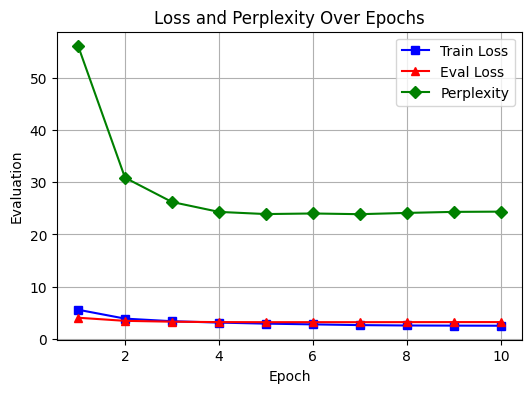

In [ ]:
# Plotting train loss, eval loss, and perplexity
plt.figure(figsize=(6, 4))
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, 'bs-', label='Train Loss')
plt.plot(epochs, eval_losses, 'r^-', label='Eval Loss')
plt.plot(epochs, perplexities, 'gD-', label='Perplexity')
plt.title('Loss and Perplexity Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Evaluation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from google.colab import files
files.download('/content/finetuned-camembert/model.safetensors')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Test Model

In [ ]:
prompt = "Conjugaison les verbes"

In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="huanghe/camemBERT_v2.0")

generator(prompt)

[{'generated_text': 'Conjugaison les verbes au présent. a. Le chien a des croines. b'}]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("huanghe/camemBERT_v2.0")
inputs = tokenizer(prompt, return_tensors="pt").input_ids

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("huanghe/camemBERT_v2.0")
outputs = model.generate(inputs, max_new_tokens=100, do_sample=True, top_k=50, top_p=0.95)

In [ ]:
tokenizer.batch_decode(outputs, skip_special_tokens=True)

['Conjugaison les verbes conjuguent à la 3 e personne du singulier et aux pluriels. Je... de la cuisine. b. Mes amis... ravis d’accueillir leurs cousins! c. À quelle date? Je.... d. Tu... raison. e. Vous... raison. f. Il te donnera la bonne réponse. g. Le matin, je... faim. h. Tu... toujours te reposer avant d’aller... la piscine. g. J’adore... la glace à la vanille']